# CAB420, DCNNs, Bonus Example: Fusing Different Modes of Data
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

This example looks at doing data fusion with DCNNs. Within the world of machine learning you'll often hear talk of fusion. This does not mean the process by which simple atoms are combined to form more complex atoms, i.e. what the sun does, which is perhaps a little disappointing (though performing nuclear fusion on a GPU would likely lead to some fairly major heat issues), but instead simply means combining multiple types of data to make decisions.

Within the world of fusion, there are broadly three main types:
* Early fusion, or input fusion. This involves combining the inputs before doing any sort of learning. This usually requires quite specific data types to work. A good example is when you have perfectly aligned RGB and Thermal video, and you can simply add a thermal channel to your RGB footage. The often very specific input requirements for this type of fusion mean that it's not often seen in practice.
* Late fusion, also known as decision fusion. In this approach, you typically have separate models for each of your modes, and you simply combine the decisions from these different models. This is generally not a great approach as you can't easily capture relationships across the different data modes.
* Intermediate fusion. This is where we're going today. In intermediate fusion, we learn some sort of representation for each mode (you can think of this as extracting features for each mode), we combine those representations, and then learn to perform the task of choice (i.e. classification, regression, etc) using that joint representation. This allows the model to learn how to combine the data, and works well with deep learning approaches.

In this example we'll use audio data. You may recall a previous Bonus Example that looked at using audio data in a DCNN. In that example, we tried to classify a small audio clip as one of 8 single word commands (stop, go, etc), and we had two approaches:
* Converting audio to an image, and then using a regular 2D CNN
* Leaving the audio as a 1D signal, and using a 1D CNN
  
Here, [we'll do both](https://youtu.be/vgk-lA12FBk). We'll create two inputs, pass each to it's own encoder, getting some features out of each encoder, concatenate them, and pass that combined thing into our classifier head.

There are lots of other bells and whistles we could add to this, in particular with respect to how we combine the two sets of features. The approach we're going to use here (concatenation) is about as simple as you can get, but this should give you some ideas of how to proceed with fusion based methods if this is something of interest.

### Where does this fit into all the other CAB420 content?

It really builds on all the other deep net stuff, particularly with the work with encoders and decoders as we're essentially just creating a network with two encoders. The method here also links up with the attention content, as attention mechanisms are often used to drive the fusion in these sorts of networks rather than relying on simple concatenation. And obviously it follows on from that other audio example (CAB420_DCNNs_Bonus_Example_DCNNs_and_Audio_Data.ipynb).

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import keras
from keras import layers
from keras import models
from IPython import display

from sklearn.metrics import confusion_matrix

tf.config.optimizer.set_jit(False)

## The Data

We're using the mini speech commands dataset. This is a dataset we can access through the tensorflow API that contains samples of 8 sample speech commands:
* right
* yes
* left
* down
* go
* no
* up
* stop

Each command has 1000 samples, and each file lasts for 1 second (or very close to). Audio is sampled at 16 kHz, meaning each sample is 16,000 in length. If we think about our MNIST datasets, we have images that were $28x28$, so we have much larger samples here.

There is also a larger dataset with about 30 commands, but for the sake of size and being able to run this quickly, we'll stick to the small version.

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Commands: ['go' 'right' 'down' 'no' 'left' 'stop' 'up' 'yes']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/f953e1af_nohash_1.wav', shape=(), dtype=string)


We'll split our data into train, validation and testing. 80% will go into training, with 10% into validation and testing.

In [3]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Data Processing

We're going to re-use a bunch of functions from the previous audio example here. In particular we're got:
* A function, decode_audio, to load the audio file. This will also provide a bit of mild pre-processing to fit the data into the range [-1 .. +1]
* A function, get_label, to extract the label for the sample. We're exploiting the structure of the data, where each class is in it's own directory.
* A function, get_waveform_and_label, which given a filename will return the extracted waveform and label
* A function, get_spectrogram, to get a spectrogram from an audio sample
* A function, dynamic_padding, to pad an audio sample to a fixed length
* A function, get_audio_spectrogram_and_label_id, that will take an audio sample, pull out a padded audio sample and a spectrogram and the label ready for input to our multi-modal network

In [4]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def dynamic_padding(inp, min_size):
    pad_size = min_size - tf.shape(inp)[0]
    paddings = [[0, pad_size]]
    return tf.pad(inp, paddings)

def get_audio_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)

  padded_audio = tf.cond(tf.less(tf.shape(audio)[0], 16000), true_fn=lambda: dynamic_padding(audio, 16000), false_fn=lambda: audio)
  padded_audio = tf.expand_dims(padded_audio, -1)
  padded_audio = tf.ensure_shape(padded_audio, (16000,1))
    
  label_id = tf.argmax(label == commands)
  return (padded_audio, spectrogram), label_id

Now, we'll use the above functions to build a mulit-modal dataset ready for input to the network.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

spectrogram_ds = waveform_ds.map(
    get_audio_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

For sanity, let's visualise a few samples. We'll pull out the audio and corresponding spectrogram and check that things seem to line up. Visually, comparing spectrograms and raw audio is not that easy, however you will see rough correspondance along the x-axis.

/tmp/ipykernel_20257/1625136889.py:33: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


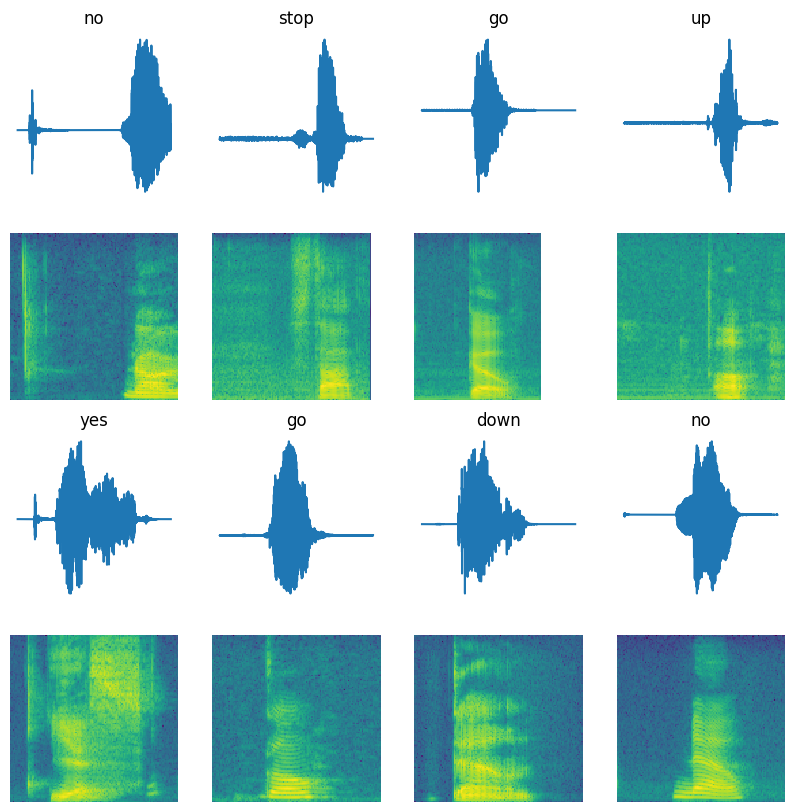

In [6]:
rows = 2
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows*2, cols, figsize=(10, 10))
for i, ((audio, spectrogram), label_id) in enumerate(spectrogram_ds.take(n)):
  r = (i // cols)
  c = i % cols
  ax = axes[r*2][c]
  ax.plot(np.squeeze(audio.numpy()))
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
    
  ax = axes[r*2 + 1][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.axis('off')

plt.show()

Finally, let's setup all the loading, and get the validation and test dataset ready as well.

In [7]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_audio_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

## Network Setup

We'll now setup our network. This is going to be something of a frankenstein network. We'll take the two networks we had in the original audio example, cut off the classification head of both of those, combine their outputs, and push that to one classification head.

As per the other example, we'll also setup some normalisation layers before we get into the network building. This will do a bit of data cleaning to help ensure that the data is consistent, which will help training. This normalisation layer will normalise each sample (pixel or audio sample) by it's mean and standard deviation, so prior to doing to this we need to calculate the means and standard deviations to use for normalisation. Hence we use the adapt function and our data to setup our normalisation.

In [8]:
for (audio, spectrogram), _ in spectrogram_ds.take(1):
  input_audio_shape = audio.shape
  input_spectrogram_shape = spectrogram.shape

print('Input audio shape:', input_audio_shape)
print('Input spectrogram shape:', input_spectrogram_shape)
num_labels = len(commands)

norm_layer_audio = layers.Normalization()
norm_layer_audio.adapt(spectrogram_ds.map(lambda x, _: x[0]))

norm_layer_spectrogram = layers.Normalization()
norm_layer_spectrogram.adapt(spectrogram_ds.map(lambda x, _: x[1]))

Input audio shape: (16000, 1)
Input spectrogram shape: (124, 129, 1)


Now, let's build a network. We've got three bits here:
* The encoder for the audio input. This will be a CNN encoder, using 1D convolutions. It will end in a flatten() layer.
* The encoder for the spectrogram input. This will be a CNN encoder, using 2D convolutions. It will also end in a flatten() layer.
* A combined classification head. This will start by combining the outputs of these two encoders via a concatenation, and then run this combined representation through a couple of dense layers to make a final classification decision.

In [9]:
# audio encoder
input_audio = layers.Input(shape=(input_audio_shape[0],1))
# normalisation straight after the input
x_aud = norm_layer_audio(input_audio)
# convolution stack
x_aud = layers.Conv1D(32, 15, activation='relu')(x_aud)
x_aud = layers.MaxPooling1D(pool_size=8, strides=4)(x_aud)
x_aud = layers.SpatialDropout1D(0.25)(x_aud)
x_aud = layers.Conv1D(64, 11, activation='relu')(x_aud)
x_aud = layers.MaxPooling1D(pool_size=8, strides=4)(x_aud)
x_aud = layers.SpatialDropout1D(0.25)(x_aud)
x_aud = layers.Conv1D(64, 7, activation='relu')(x_aud)
x_aud = layers.MaxPooling1D(pool_size=4, strides=2)(x_aud)
x_aud = layers.Conv1D(64, 7, activation='relu')(x_aud)
x_aud = layers.MaxPooling1D(pool_size=4, strides=2)(x_aud)
x_aud = layers.SpatialDropout1D(0.25)(x_aud)
# flatten to get final audio representation
x_aud = layers.Flatten()(x_aud)

# image (spectrogram) encoder
input_spe = layers.Input(shape=input_spectrogram_shape)
# bit of pre-processing first up, resize and normalisation
x_spe = layers.Resizing(32, 32)(input_spe)
x_spe = norm_layer_spectrogram(x_spe)
# convolution stack
x_spe = layers.Conv2D(32, 3, activation='relu')(x_spe)
x_spe = layers.MaxPooling2D()(x_spe)
x_spe = layers.Conv2D(64, 3, activation='relu')(x_spe)
x_spe = layers.MaxPooling2D()(x_spe)
x_spe = layers.Dropout(0.25)(x_spe)
# flatten to final image (spectrogram) representation
x_spe = layers.Flatten()(x_spe)

# combined classification head, concatenate, and then pass combined representation through to the output
x = layers.Concatenate()([x_aud, x_spe])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_labels)(x)

# build the combined model, we've got two inputs, and one output
model_fused = keras.Model(inputs=(input_audio, input_spe), outputs=output, name='audio_fusion')
model_fused.summary()

Model: "audio_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16000, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 16000, 1)  │          3 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 15986, 32) │        512 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 3995, 32)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 3995, 32)  │          0 │ max_pooling1d[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3985, 64)  │     22,592 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 124, 129,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 995, 64)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 32, 32, 1) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 995, 64)   │          0 │ max_pooling1d_1[… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 32, 32, 1) │          3 │ resizing[0][0]    │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 989, 64)   │     28,736 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │        320 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 493, 64)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 487, 64)   │     28,736 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 13, 13,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 242, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,377,934 (9.07 MB)

 Trainable params: 2,377,928 (9.07 MB)

 Non-trainable params: 6 (32.00 B)

Model compilation and training is then the same as we've been doing.

Note that depsite now having two inputs, we're not doing much different in terms of passing stuff into our network. This is because all the magic has been done in the data loaders, so the data loaders are producing a pair of inputs for each sample. If we weren't using these, we'd be passing in a list of inputs to the model.

In [10]:
model_fused.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'], jit_compile=False
)

num_epochs = 40
history = model_fused.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=num_epochs,
    callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True),
)

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 366ms/step - accuracy: 0.2427 - loss: 2.0011 - val_accuracy: 0.5063 - val_loss: 1.4916
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.4544 - loss: 1.4699 - val_accuracy: 0.6050 - val_loss: 1.1459
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.5752 - loss: 1.1944 - val_accuracy: 0.6825 - val_loss: 0.9603
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.6314 - loss: 1.0282 - val_accuracy: 0.6900 - val_loss: 0.8991
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.6672 - loss: 0.9249 - val_accuracy: 0.7325 - val_loss: 0.7917
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.7075 - loss: 0.8384 - val_accuracy: 0.7663 - val_loss: 0.7119
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.7288 - loss: 0.7632 - val_accuracy: 0.7825 - val_loss: 0.6869
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.7480 - loss: 0

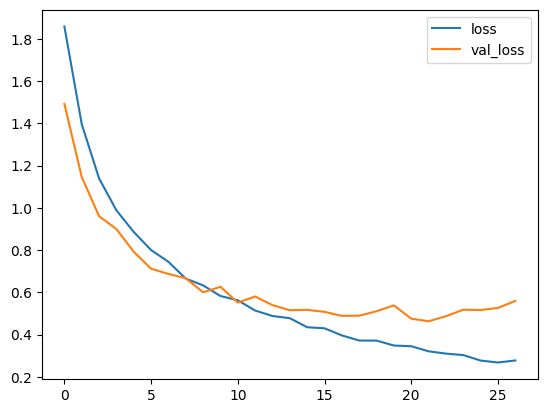

In [11]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Accuracy wise, our model is pretty good again, and unsurprisingly we again see the most confusion between "go" and "no".

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Test set accuracy: 86%


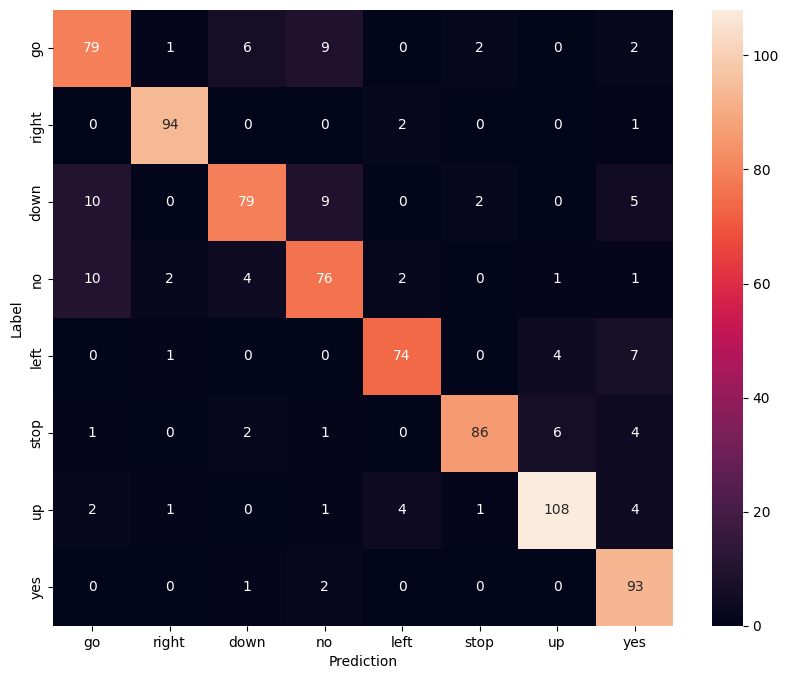

In [12]:
test_audio = []
test_spectro = []
test_labels = []

for (audio, spectro), label in test_ds:
  test_audio.append(audio.numpy())
  test_spectro.append(spectro.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_spectro = np.array(test_spectro)
test_labels = np.array(test_labels)

y_pred = np.argmax(model_fused.predict((test_audio, test_spectro)), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Performance on the whole is about as good as what we had with the single mode networks. You may see slight improvements or drops depending on what chance delivers you on a given training run, but you're almost certainly not seeing epic performance gains. Let's briefly consider why this might be so:
* First up, we're not adding any new information here. We've got two representations of the same data, so we're limited in how much extra knowledge we can derive from that.
* Our fusion is very simple. When we consider each mode individually, we saw the spectrogram approach (the image one) worked better. Yet here, we've got two embeddings from our two modes that we're just sticking together side-by-side, with the assumption that both are equally good. We're then simply hoping that the couple of dense layers after that concatenation can figure out what's meaningful across the two input streams. Ideally (in some hypothetical follow-on unit to CAB420) we'd use attention mechanisms and similar things to identify complementary information in the two streams and fuse data more efficiently, which would lead to improved performance.
* As we noted in the audio example, we've got a bunch of other issues here which limit our performance. There's the small dataset size, the small spectrograms, the use of Conv1Ds for our audio data rather than cooler and fancier things, and the fact that we're training this from scratch rather than using pre-trained models that would give us greater performance.

## Final Thoughts

So what have we learned today? Is fusion a complete waste of time?

The above does show how you can combine multiple inputs quite easily with deep nets, but it also shows that simply whacking two inputs in side-by-side is not guaranteed to make everything awesome. Consideration does need to be given the level of information each input is contributing, and to how complementary knowledge is actually pulled out from the modes. There are a number of reasons why performance does not jump here (see above), but a well designed fusion scheme, where you have complementary information coming from the inputs, can lead to nice performance gains.

That said, one limitation with fusion is of course that you now need input data for two (or more) modes, and with those you now have multiple sources of noise, which can pose a challenge. While data requrirements can increase due to the larger input space, you can use multiple pre-trained networks within a fusion scheme. Taking pre-trained models for image, audio, text, and whatever other modes you have, concatenating embeddings from these, and fine-tuning the lot is totally acceptable and a very well worn approach.

So, as for the question of *is fusion any good?*, as always it's a case of it depends. If you have complementary information from the modes, and aren't worried about one (or more) of the modes being sometimes degraded or unavailable, then it can be great, otherwise it may not be worth the effort.